In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

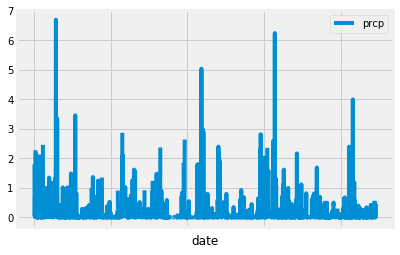

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_obj = datetime.strptime(last_date[0], '%Y-%m-%d').date()
year_ago = last_date_obj - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'prcp'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='date', y='prcp')

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [28]:
ss = session.query(Station).all()
ss[0].__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x120d4c2b0>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [13]:
mm = session.query(Measurement).all()
mm[0].__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e6aed68>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [14]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station.station).count()
print(f'There are {stations_count} stations.')

There are 9 stations.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_ss = session.query(Measurement.station, Measurement.date, Measurement.tobs).all()
active_df = pd.DataFrame(active_ss, columns=['Station', 'Date', 'Temperature'])
most_active = active_df['Station'].value_counts()
most_active

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Station, dtype: int64

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps_df = active_df.loc[active_df['Station']==most_active.index[0], :]
max_temp = temps_df['Temperature'].max()
min_temp = temps_df['Temperature'].min()
mean_temp = temps_df['Temperature'].mean()
print(f'The highest temperature is {max_temp} F.')
print(f'The lowest temperature is {min_temp} F.')
print(f'The highest temperature is {mean_temp} F.')

The highest temperature is 85.0 F.
The lowest temperature is 54.0 F.
The highest temperature is 71.66378066378067 F.


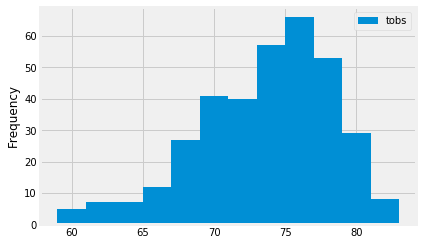

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
ActSMo = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.date >= year_ago).all()
ActSMo_df = pd.DataFrame(ActSMo)
twelvemo_df = ActSMo_df.loc[ActSMo_df['station']==most_active.index[0], :]
twelvemo_df.plot(kind='hist', bins=12)


In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Coincidentally, I am planning an actual trip to Hawaii this year in August so I used those dates.
# Used data from two years ago instead of last year though.
trip_temps = calc_temps('2017-08-05', '2017-08-12')
print(f'The lowest temperature during your trip is {trip_temps[0][0]} F.')
print(f'The average temperature during your trip is {trip_temps[0][1]} F.')
print(f'The highest temperature during your trip is {trip_temps[0][2]} F.')

The lowest temperature during your trip is 71.0 F.
The average temperature during your trip is 79.36666666666666 F.
The highest temperature during your trip is 83.0 F.


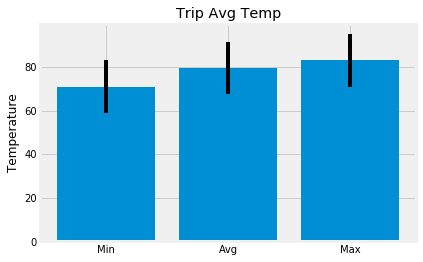

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
labels = ('Min', 'Avg', 'Max')
y = np.arange(len(labels))
temps = [trip_temps[0][0],trip_temps[0][1],trip_temps[0][2]]
plt.bar(y, temps, yerr=(trip_temps[0][2]-trip_temps[0][0]))
plt.xticks(y, labels)
plt.ylabel('Temperature')
plt.title('Trip Avg Temp')
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
triprain = session.query(Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= dt.date(2017, 8, 5)).filter(Measurement.date <= dt.date(2017, 8, 12)).all()
triprain_df = pd.DataFrame(triprain)
triprain_df = triprain_df.groupby('station').sum()
triprain_df = triprain_df.reset_index()

ss = session.query(Station.station, Station.name, Station.latitude, Station.longitude).all()
ss_df = pd.DataFrame(ss, columns=['station', 'name', 'lat', 'long'])
merge_df = triprain_df.merge(ss_df, on='station')
rain_during_trip = merge_df.sort_values('prcp', ascending=False)
rain_during_trip


,station,prcp,name,lat,long
1,USC00516128,0.75,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250
0,USC00514830,0.10,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740
2,USC00519281,0.06,"WAIHEE 837.5, HI US",21.45167,-157.84889
3,USC00519397,0.00,"WAIKIKI 717.2, HI US",21.27160,-157.81680
4,USC00519523,0.00,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139
